# Test passive membrane properties using neurons with different time constants

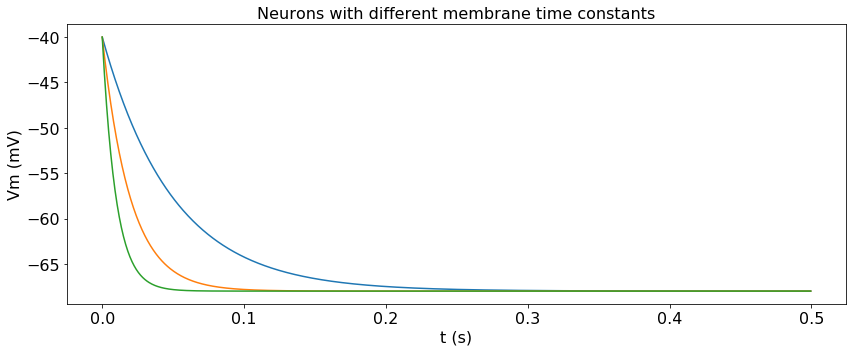

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_leak = -0.068 * np.ones(3)
v_th = -0.036 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))

vs_init = -0.04 * np.ones(3)

ntwk = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, dt=dt, vs_init=vs_init)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants')

set_font_size(ax, 16)

# Extend to case of synaptic-input-induced spiking

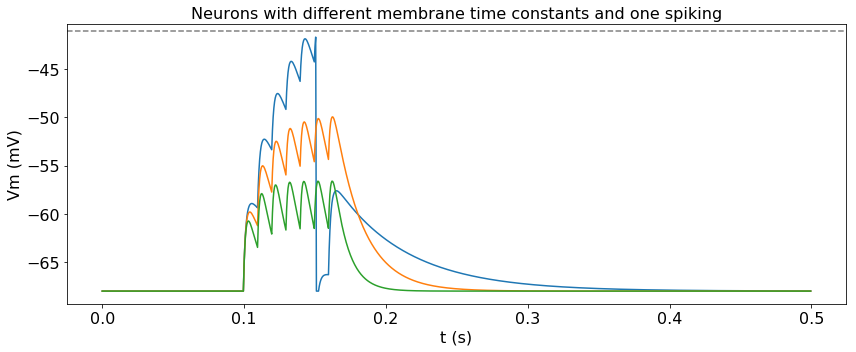

In [2]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_leak = -0.068 * np.ones(3)
v_th = -0.041 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': 0.04 * np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))
ts_spks_up = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]

for t in ts_spks_up:
    spks_up[int(t/dt), :] = 1

vs_init = e_leak * np.ones(3)

ntwk = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, dt=dt, vs_init=vs_init)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.axhline(-41, color='gray', ls='--')

ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants and one spiking')

set_font_size(ax, 16)

# Test afterhyperpolarization

Here we show a neuron's response to tetanic stimulus with and without afterhyperpolarization.

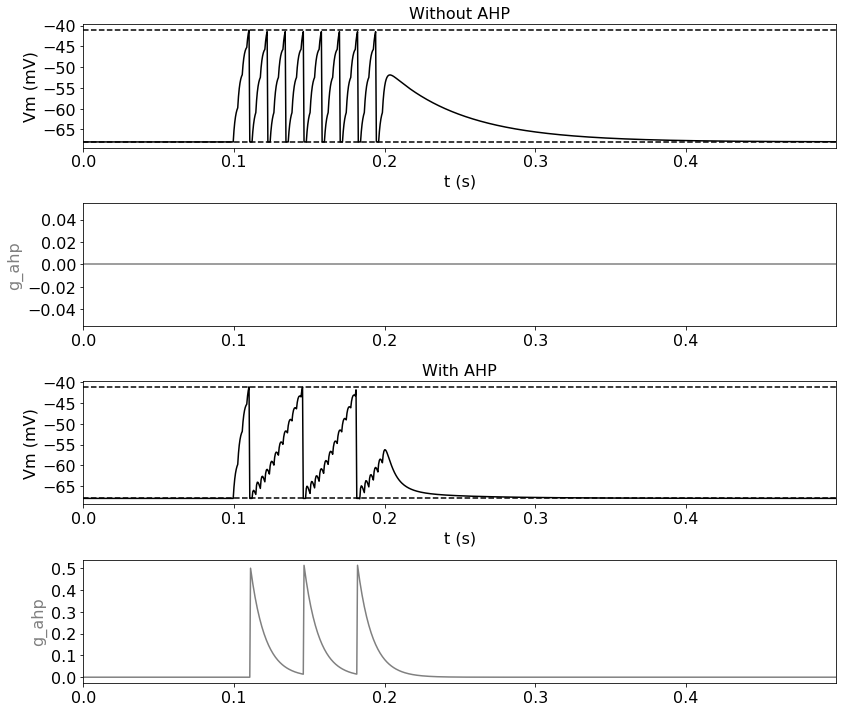

In [19]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05])
e_leak = -0.068 * np.ones(1)
v_th = -0.041 * np.ones(1)
v_reset = -0.068 * np.ones(1)
t_r = 0.002
e_ahp = -0.07
t_ahp = 0.01
w_ahp = 0.5
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((1, 1))}
ws_up = {'AMPA': 0.04 * np.eye(1)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)

# set up input spikes
spks_up = np.zeros((len(ts), 1))
ts_spks_up = np.arange(0.1, 0.2, 0.003)

for t in ts_spks_up:
    spks_up[int(t/dt), 0] = 1
    
# set up initial voltage
vs_init = e_leak * np.ones(1)

# run basic ntwk
ntwk_basic = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp_basic = ntwk_basic.run(spks_up=spks_up, dt=dt, vs_init=vs_init)

# run ntwk with nonzero AHP term
ntwk_ahp = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    e_ahp=e_ahp, t_ahp=t_ahp, w_ahp=w_ahp,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp_ahp = ntwk_ahp.run(spks_up=spks_up, dt=dt, vs_init=vs_init)

resps = [resp_basic, resp_ahp]
titles = ['Without AHP', 'With AHP']

# plot both ntwk responses
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True)
axs = [axs[:2], axs[2:]]

for axs_, resp, title in zip(axs, resps, titles):
    
    axs_[0].plot(ts, 1000 * resp.vs, color='k')
    axs_[0].axhline(1000*e_leak, color='k', ls='--')
    axs_[0].axhline(1000*v_th, color='k', ls='--')
    axs_[0].set_xlim(ts[0], ts[-1])
    
    axs_[0].set_xlabel('t (s)')
    axs_[0].set_ylabel('Vm (mV)')
    axs_[0].set_title(title)
    
    axs_[1].plot(ts, resp.g_ahp, color='gray')
    axs_[1].set_xlim(ts[0], ts[-1])

    axs_[1].set_ylabel('g_ahp', color='gray')
    
    for ax in axs_:
        set_font_size(ax, 16)